In [1]:
import pandas as pd
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
0,CC(C)c1nnc2ccc(-c3c[nH]nc3-c3cc(F)ccc3F)cn12,8.55,339.349,4.18800,0.608797
1,CC(=O)Nc1cnccc1CCOc1ccc(NC(=O)N=c2cc(C(C)(C)C)...,8.10,576.701,6.67222,0.200740
2,Cc1ccc(-n2[nH]c(C(C)(C)C)cc2=NC(=O)Nc2ccc(OCCN...,7.81,527.669,5.40832,0.351338
3,O=c1ncc2c(-c3ccccc3Cl)cc(C(O)N3CCNCC3)cc2n1-c1...,8.82,515.828,4.90900,0.404159
4,Cn1c(-c2cn(C(C)(C)C(=O)O)nn2)nc(-c2ccc(F)cc2)c...,5.83,406.421,3.36640,0.545632
...,...,...,...,...,...
1440,CCN(C(=O)c1csc2ccccc12)c1cc[nH]c(=NC(C)c2ccccc...,6.73,402.523,4.95300,0.513182
1441,COc1cc2[nH]cnc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...,7.30,597.720,4.46092,0.290574
1442,CN1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl)ccc...,9.30,518.847,7.62340,0.386913
1443,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2C)cc1-c1ccc2[nH...,8.05,547.625,6.50444,0.289316


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,CC(C)c1nnc2ccc(-c3c[nH]nc3-c3cc(F)ccc3F)cn12,8.55,339.349,4.18800,0.608797,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)Nc1cnccc1CCOc1ccc(NC(=O)N=c2cc(C(C)(C)C)...,8.10,576.701,6.67222,0.200740,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Cc1ccc(-n2[nH]c(C(C)(C)C)cc2=NC(=O)Nc2ccc(OCCN...,7.81,527.669,5.40832,0.351338,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,O=c1ncc2c(-c3ccccc3Cl)cc(C(O)N3CCNCC3)cc2n1-c1...,8.82,515.828,4.90900,0.404159,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cn1c(-c2cn(C(C)(C)C(=O)O)nn2)nc(-c2ccc(F)cc2)c...,5.83,406.421,3.36640,0.545632,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1440,CCN(C(=O)c1csc2ccccc12)c1cc[nH]c(=NC(C)c2ccccc...,6.73,402.523,4.95300,0.513182,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1441,COc1cc2[nH]cnc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...,7.30,597.720,4.46092,0.290574,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1442,CN1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl)ccc...,9.30,518.847,7.62340,0.386913,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1443,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2C)cc1-c1ccc2[nH...,8.05,547.625,6.50444,0.289316,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Now incorporate this sort of noise into df during the training

In [7]:
X.shape

(1445, 2048)

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        print(trues)
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_MLP_training batches.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_MLP_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [9]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.5764886151532648, 3.998045106368325e-14)
                                   Standardized_SMILES  actual  predictions
0               O=C1c2ccccc2CCc2cc(Nc3ccc(F)cc3F)ccc21    7.02     5.819232
1    COCCn1c(SCc2ccc([S+](C)[O-])cc2)nc(-c2ccc(F)cc...    6.82     6.147416
2    O=C(NC1C(O)OC(CO)C(O)C1O)c1ccc2c(c1)C(=O)c1ccc...    8.28     8.650596
3      Cc1cc(F)ccc1Oc1ccc2c(-c3cc(C(N)=O)ccc3C)nncc2n1    6.38     6.589477
4    N=c1c(C(=O)c2cccc(CCCN3CCOCC3)c2)c[nH]n1-c1ccc...    5.76     6.227605
..                                                 ...     ...          ...
139  O=C1NCc2c(-c3ccccc3Cl)nc(N3CCOCC3)nc2N1c1c(Cl)...    8.70     7.215856
140          Cc1ccc(C(N)=O)cc1-c1ccc2c(c1)NC(=O)C2(C)C    7.10     5.810727
141         CN=c1nc2c(c[nH]1)cc(Oc1ccc(F)cc1F)c(=O)n2C    6.58     5.581178
142  CNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c(C(=O)N...    6.18     7.352705
143  Cc1cc(F)c(NC(=O)c2ccsc2)cc1Nc1ccc2c(c1)OCc1ccc...    7.88     9.427720

[136 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7537754386061799, 1.1277334456112027e-27)
                                   Standardized_SMILES  actual  predictions
0    CSc1nc(-c2cc[nH]c(=NC(=O)C3CCCO3)c2)c(-c2ccc(F...    7.55     8.080563
1    NC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c(NC(=O)c...    9.52     8.183342
2        CCCN=c1[nH]c2cn(-c3cc(C(=O)NCC)ccc3C)c(O)c2s1    6.80     6.621505
4    CCCc1c(C(=O)Nc2cc(S(=O)(=O)N(C)C)ccc2C)cnn1Cc1...    7.28     7.391074
5    CC(=O)N=c1cc(COc2ccc(NC(=O)N=c3cc(C(C)(C)C)[nH...    8.70     6.936720
..                                                 ...     ...          ...
139  CCCc1c(C(=O)Nc2cc(S(=O)(=O)N(C)C)ccc2C)cnn1CC(C)C    7.12     6.394405
140       CC1(c2nnc3ccc(-c4ocnc4-c4ccc(F)cc4F)cn23)CC1    9.15     8.632038
141  O=C1CCc2c(-c3ccc(F)cc3F)cc(C3CCNCC3)cc2N1c1c(C...    9.13     8.369480
142  CCc1nc(-c2cccc(C)c2)c(-c2cc[nH]c(=NC(=O)Cc3ccc...    8.25     8.403171
143  CNC(=O)c1ccc(C)c(N=c2[nH]cnc3c2cnn3-c2c(C)cc(C...    7.62     6.936918

[132 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8283532586601845, 1.4819710438745163e-37)
                                   Standardized_SMILES  actual  predictions
1               O=c1ncn2nc(Sc3ccccc3)ccc2c1-c1ccccc1Cl    5.30     6.627280
2    Cc1c(F)cc(C(=O)NC2CC2)cc1-c1ccc2c(c1)NC(=O)C21...    9.00     9.280233
3    Cc1ccc(C(=O)NC2CC2)cc1-n1cnc2ccc(N3CCN(C)CC3)c...    7.70     7.233727
4              CNC(=O)c1ccc(C)c(N=c2[nH]cnc3c2cnn3C)c1    6.60     6.381035
5    CC(=O)N=c1cc(-c2c(-c3ccc(F)cc3)nc(SC3CCC(C(=O)...    6.12     5.815296
..                                                 ...     ...          ...
139  Cc1ccc(C(=O)NC2CC2)cc1-n1cc[nH]c(=NC(c2ccccc2)...    9.40     9.103322
140  N=c1cc(Oc2ccc(NC(=O)Nc3cccc(C(F)(F)F)c3)cc2)[n...    6.00     5.301710
141  CC1(C)OCC(COc2ccc3c(c2)COc2cc(Nc4ccc(F)cc4F)cc...    6.18     7.316122
142  O=C(Cc1ccccc1)N=c1[nH][nH]c(-c2ccc(F)cc2)c1-c1...    7.78     8.120895
143  COc1nc2[nH]ccc2cc1C(=O)N1CCn2c(cnc2-c2ccc(F)cc...    6.79     6.988103

[134 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8233203055201823, 9.540317019777715e-37)
                                   Standardized_SMILES  actual  predictions
0    CCN(C(=O)c1ccc2occc2c1)c1cc[nH]c(=NC(C)c2ccccc...    7.15     7.219268
1    COc1cc2c(cc1C(=O)N1CCn3c(cnc3-c3ccc(F)cc3F)C1)...    7.89     7.082158
2    COc1cc2[nH]cnc(=Nc3ccc(Cl)c(NC(=O)c4cccc(N(C)C...    5.77     7.117011
3    Cc1nnc(-c2ccc(C)c(-c3ccc4c(c3)NC(=O)C43CCCC3)c...    7.50     7.521631
4    O=C(Nc1ccc(F)c(Nc2ccc3c(c2)CCc2ccc(OCCO)cc2C3=...    8.70     9.200930
..                                                 ...     ...          ...
139         CC(C)c1nnc2ccc(-c3ocnc3-c3ccc(F)cc3Cl)cn12    8.60     8.915919
140  COCCNC(=O)c1ccc(-c2c(N)c(C(=O)c3ccc(F)cc3F)cc[...    7.16     7.656065
141  COC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)cc3F)cc1CC2    8.70     8.046901
142        Cc1ncccc1-c1nncc2[nH]c(=Nc3ccc(F)cc3F)ccc12    8.92     8.655368
143  Cn1c(=O)cc(Nc2cc(C(=O)NC3CC3)ccc2F)c2cnn(-c3cc...    7.89     8.840234

[139 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8079125733818631, 2.014180796918237e-34)
                                   Standardized_SMILES  actual  predictions
0             Cc1cccc(-c2ncoc2-c2ccc3nnc(C(C)C)n3c2)c1    7.74     8.637265
1    O=C(O)C=CSc1nc(-c2cc[nH]c(=Nc3ccccc3)c2)c(-c2c...    7.44     7.641288
2    CCOP(=O)(CCn1cc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3...    5.61     5.500150
3    CC(C)S(=O)(=O)n1c(=N)[nH]c2ccc(-c3[nH]c(-c4c(F...    8.31     7.980906
4     O=C1c2cc(OCC(O)CO)ccc2COc2cc(Nc3ccc(F)cc3F)ccc21    7.53     7.634780
..                                                 ...     ...          ...
137  Cc1cc(Cl)ccc1Sc1ccc2c(-c3c(Cl)cccc3Cl)c(=O)ncn2n1    6.75     6.822543
138   Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(n1)NC(=O)C21CCCC1    8.25     7.700372
140  CC(C)(C)CN=c1nc(-c2ccccc2Cl)c2c([nH]1)N(c1c(Cl...    9.10     9.354542
141   Cn1c(=O)c(Oc2cccc(F)c2)cc2c[nH]c(=NC3CCOCC3)nc21    6.23     7.426806
142  Cc1ccc(NC(=O)c2cccc(N3CCOCC3)c2)cc1NC(=O)c1ccc...    7.05     8.473785

[135 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7866673708918438, 1.533105951948138e-31)
                                   Standardized_SMILES  actual  predictions
0       CNC(=O)c1ccc(C)c(-n2cc3[nH]c(=NC(C)C)sc3c2O)c1   6.960     7.105493
1    COCCNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)cc3F)...   8.300     7.734514
2    CCN(C(=O)c1ccc(C)c(C)c1)c1cc[nH]c(=NC(C)c2cccc...   7.040     6.318290
3    Cc1ccc(NC(=O)c2ccnc(N3CCOCC3)c2)cc1N=c1cc[nH]c...   7.050     7.220214
4    COc1cc2[nH]cnc(=Nc3ccc(Cl)c(NC(=O)c4ccccc4)c3)...   6.210     5.361477
..                                                 ...     ...          ...
138            Cc1ccccc1-c1nncc2nc(Oc3ccc(F)cc3F)ccc12   9.700     8.827371
140  Cc1ccc(-n2[nH]c(C(C)C)cc2=NC(=O)Nc2ccc(Oc3ccnc...   8.700     7.889829
141  CC(NC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)cc3F)c...   7.355     8.085818
142  CN=c1cc(Oc2c(C)cc(NC(=O)Nc3cccc(C(F)(F)F)c3)cc...   5.700     6.785136
143  CSc1nccc(-c2[nH]c(-c3ccc(O)cc3)nc2-c2ccc(F)cc2)n1   7.020     7.222265

[130 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7831351339826759, 4.29366708242587e-31)
                                   Standardized_SMILES  actual  predictions
0          CC(C)c1nnc2ccc(-c3ocnc3-c3ccc(Cl)cc3Cl)cn12    8.08     8.204282
1        CCCc1c(C(=O)Nc2cc(C(=O)OC)ccc2C)cnn1-c1ccccc1    6.31     7.405610
2    O=C(Cc1ccccc1)N=c1o[nH]c(-c2c(Cl)cccc2Cl)c1-c1...    6.00     6.977007
3    CC(CS(C)(=O)=O)N=c1nc2c(c[nH]1)cc(Oc1ccc(F)cc1...    7.80     8.091417
5    Cn1c(=O)c(Oc2ccc(F)cc2F)cc2c[nH]c(=NCCS(C)(=O)...    6.65     8.225508
..                                                 ...     ...          ...
137  NC(CCCCNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)cc...    8.46     8.350985
138                N=c1o[nH]c(-c2ccc(F)cc2)c1-c1ccncc1    6.98     6.147174
139  Cc1cccc(-c2nc(C)sc2-c2cc[nH]c(=NC(=O)c3ccccc3)...    7.89     6.763544
141  Cc1cc(C(=O)O)ccc1-c1c(N)c(C(=O)c2ccc(F)cc2F)cc...    6.31     7.733728
142  CCc1nc(-c2cccc(C(F)(F)F)c2)c(-c2cc[nH]c(=NC(=O...    7.04     7.338325

[134 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7954371517938048, 1.0901257436460546e-32)
                                   Standardized_SMILES  actual  predictions
0    CCCN1CCC(Oc2nc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...    7.30     7.528993
1    Cc1noc(-c2ccc(C)c(-c3ccc4c(c3)NC(=O)C43CCCC3)c...    6.13     7.371471
3    COC(O)c1cc(-c2ccc(Cl)cc2)c2cnc(=O)n(-c3c(Cl)cc...    7.33     6.958600
5    [O-][n+]1ccc2c(-c3ccccc3Cl)cc(C3CCNCC3)nc2c1-c...    9.57     9.073824
6    CCN(C(=O)c1ccc2c(c1)CCC2)c1cc[nH]c(=NC(C)c2ccc...    7.35     6.523431
..                                                 ...     ...          ...
139  CNC(=O)c1ccc(C)c(N=c2[nH]c(C)nc3c2cnn3-c2ccccc...    7.75     7.962102
140  COc1cc2[nH]cnc(=Nc3cccc(NC(=O)c4ccccc4)c3)c2cc1OC    6.85     6.121790
141  O=C(NCCO)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c(NC(=...    9.52     9.086610
142  COCCNC(=O)c1ccc(-c2c3nccc(-c4ccc(F)cc4F)c3cc[n...    5.85     6.813060
143  CC(C)N1CCN(c2nc(-c3ccc(Cl)cc3Cl)c3c(n2)N(c2c(C...    7.70     8.807564

[138 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8805209676251082, 1.6306035442024352e-49)
                                   Standardized_SMILES  actual  predictions
0    O=C(NCC(O)CO)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c(...    8.17     8.043874
1    Cc1ccc(-n2[nH]c(C3CC3)cc2=NC(=O)Nc2ccc(Oc3ccnc...    8.70     8.025346
3    NC(=O)CCNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c...    8.21     8.851186
4          CNC(=O)c1cc(-n2ncc3cc(Nc4ccccc4Cl)cnc32)cs1    6.32     6.681647
5    Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1-c1ccc2[nH]...    8.22     7.824323
..                                                 ...     ...          ...
144  CCN(C(=O)c1csc2ccccc12)c1cc[nH]c(=NC(C)c2ccccc...    6.73     5.916854
145  COc1cc2[nH]cnc(=Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4...    7.30     7.573683
146  CN1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c(Cl)ccc...    9.30     9.174393
147  Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2C)cc1-c1ccc2[nH...    8.05     7.752791
148  Cc1ccc(NC(=O)c2ccnc(N3CCOCC3)c2)cc1N=c1cc[nH]c...    7.52     7.829046

[141 rows x 3 columns]


In [10]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(1, 3)
(4, 3)
(2, 3)
(0, 3)
(2, 3)
(5, 3)
(0, 3)
(1, 3)
(3, 3)


In [11]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(5, 3)
(3, 3)
(4, 3)
(1, 3)
(2, 3)
(4, 3)
(7, 3)
(0, 3)
(3, 3)


In [12]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(1, 3)
(4, 3)
(4, 3)
(4, 3)
(5, 3)
(5, 3)
(3, 3)
(4, 3)
(2, 3)


In [13]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(136, 3)
(132, 3)
(134, 3)
(139, 3)
(135, 3)
(130, 3)
(134, 3)
(138, 3)
(141, 3)


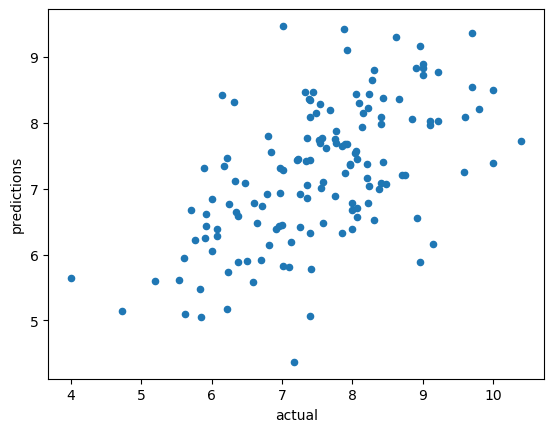

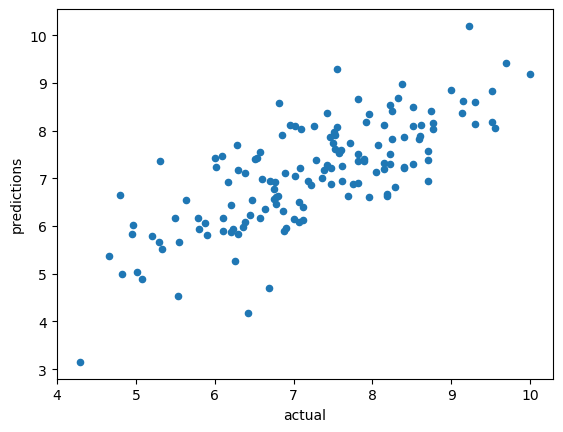

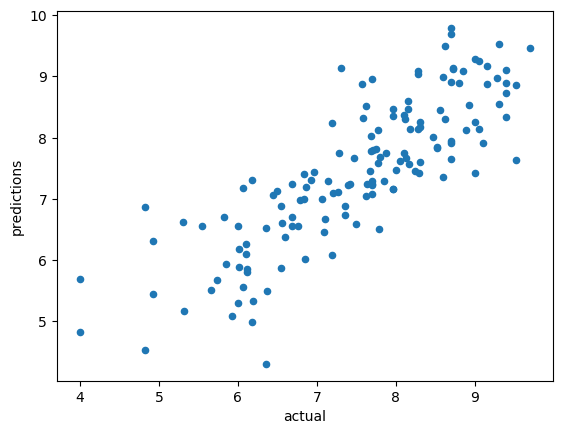

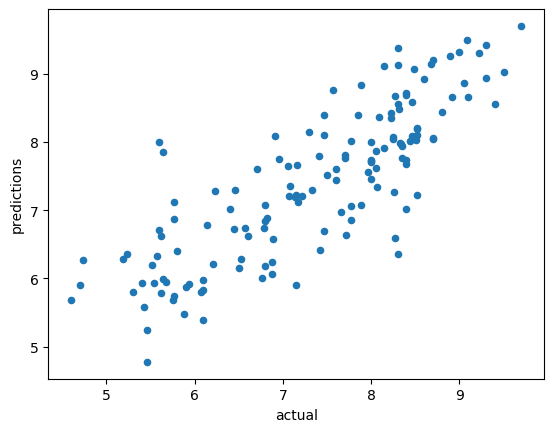

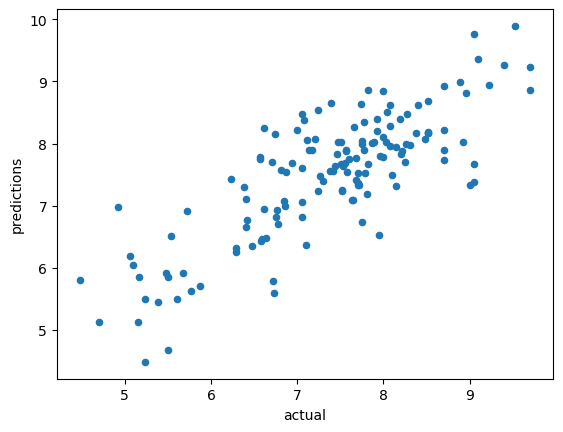

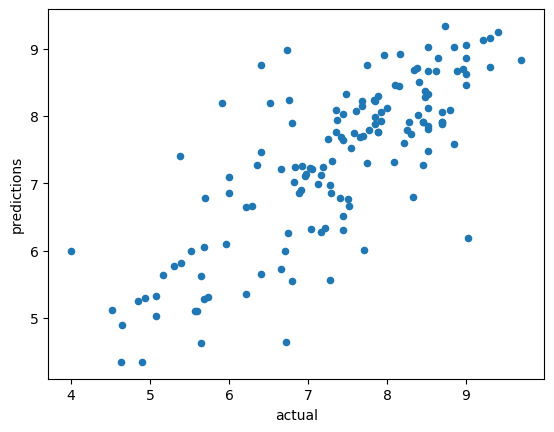

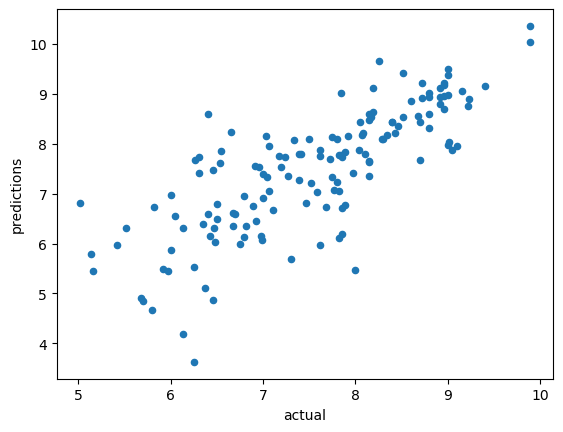

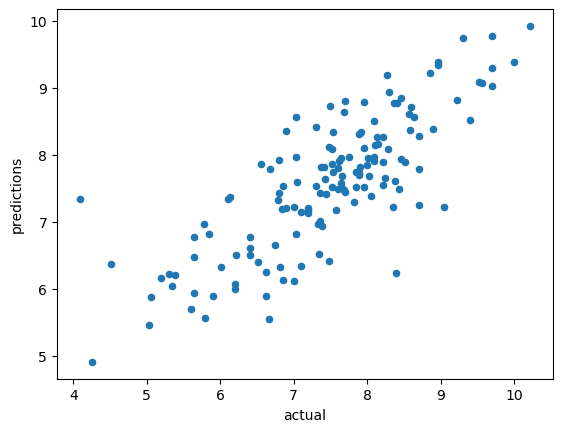

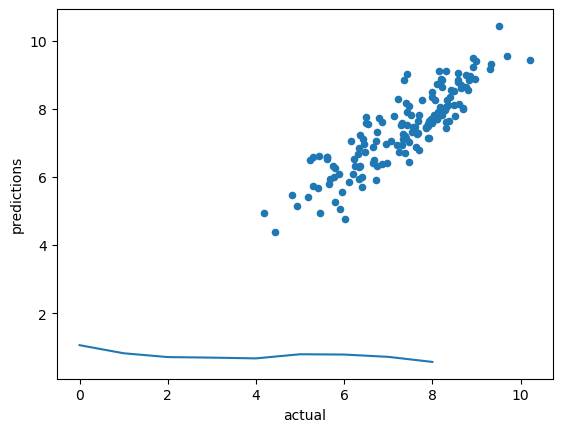

[1.0616123518091658, 0.8238488855166036, 0.7118957307046375, 0.6960204976489547, 0.6736982450607402, 0.7951953827593948, 0.7863619159257961, 0.7186046202488228, 0.5699150820178445]


In [14]:
plt.plot(rmse)
plt.show()
print(rmse)

In [15]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

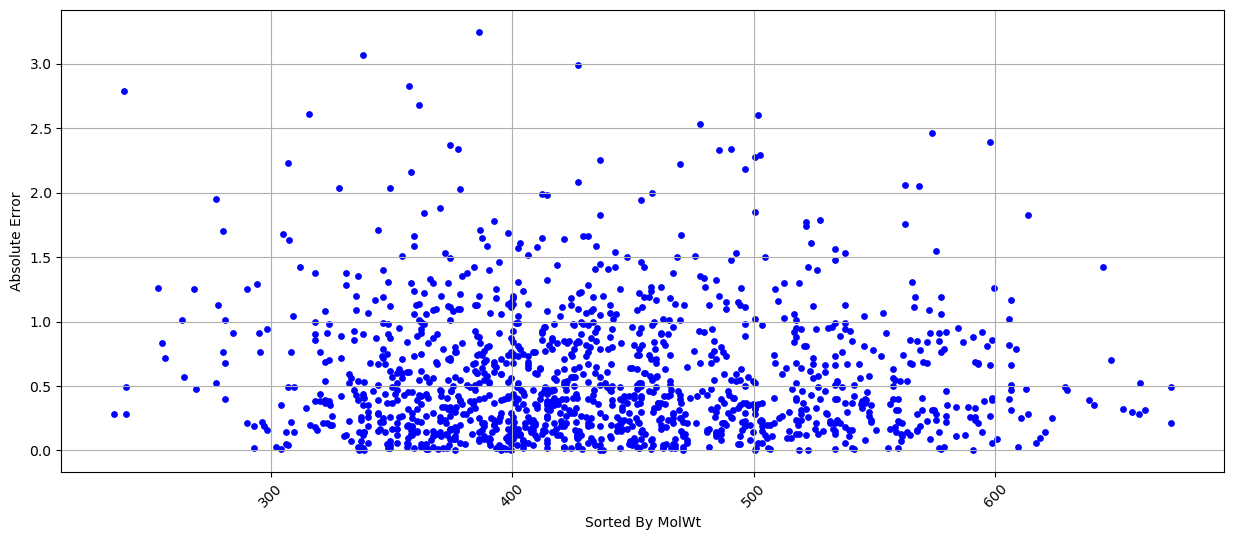

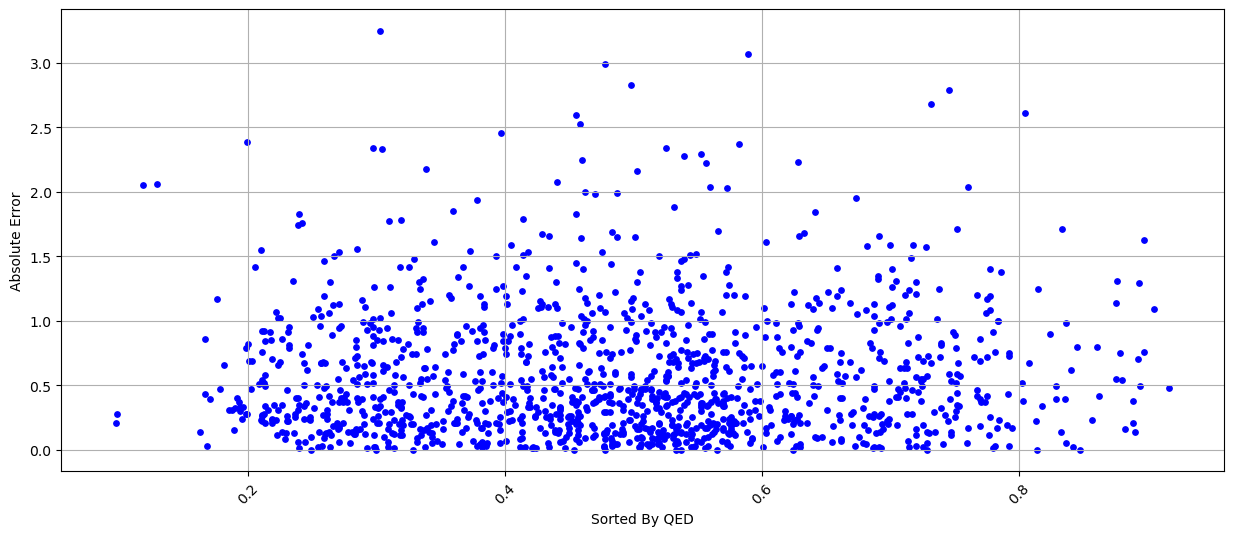

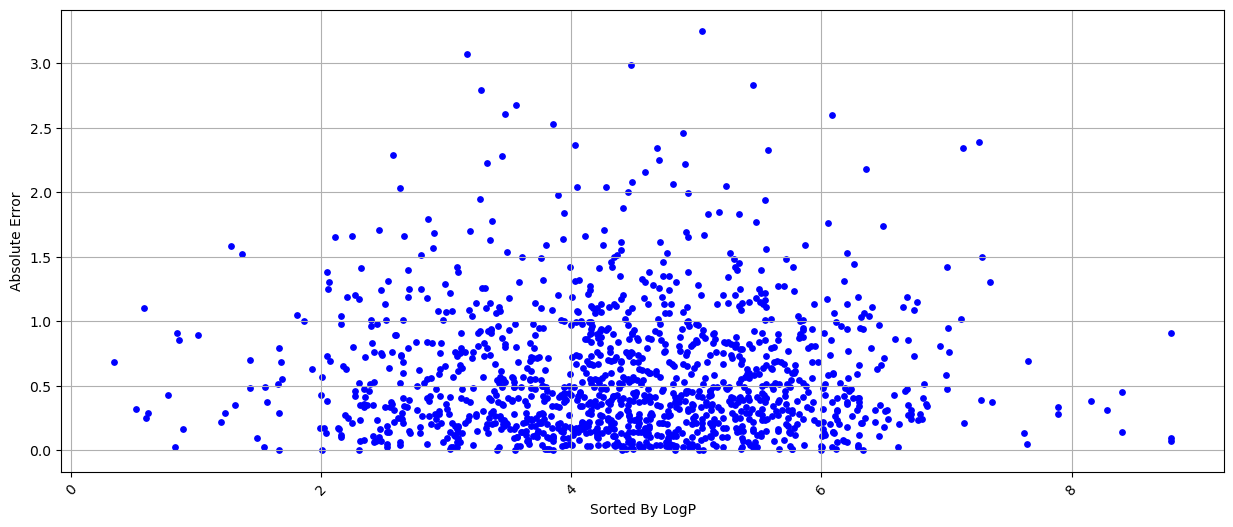

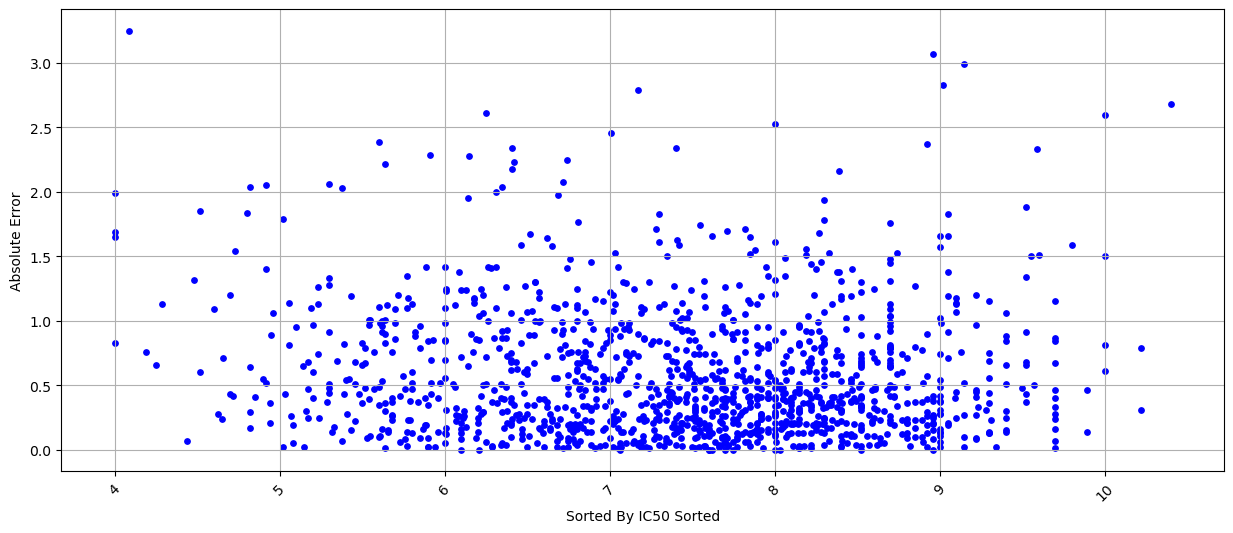

In [16]:
plot_graphs(df, results_df)

In [17]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [18]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_MLP_training batches_druglike.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_MLP_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [19]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.5786475252576246, 3.054204220678782e-14)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.6348249192874533, 1.2943645100685424e-17)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.678621414859887, 9.115638784440879e-21)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7829158806430179, 4.574191728543941e-31)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.732940329345005, 1.58572470319781e-25)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7054384432924523, 5.564659812429347e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7103438583308029, 2.0570650211989857e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7111284155890061, 1.751016900844854e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7577477694342176, 4.151698192738911e-28)


In [20]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(3, 3)
(3, 3)
(3, 3)
(0, 3)
(0, 3)
(3, 3)
(1, 3)
(1, 3)
(1, 3)


In [21]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(18, 3)
(4, 3)
(5, 3)
(7, 3)
(10, 3)
(13, 3)
(13, 3)
(6, 3)
(7, 3)


In [22]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(120, 3)
(134, 3)
(133, 3)
(131, 3)
(128, 3)
(125, 3)
(125, 3)
(132, 3)
(131, 3)


In [23]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(3, 3)
(3, 3)
(3, 3)
(6, 3)
(6, 3)
(3, 3)
(5, 3)
(5, 3)
(5, 3)


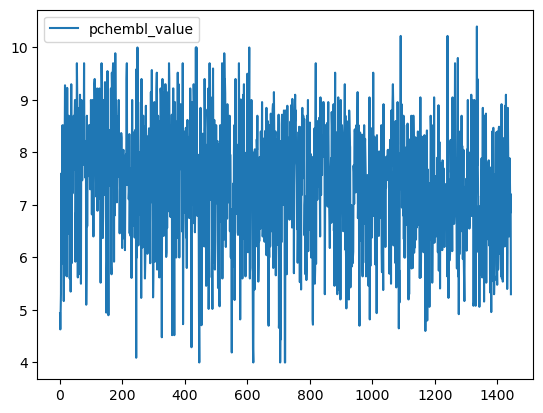

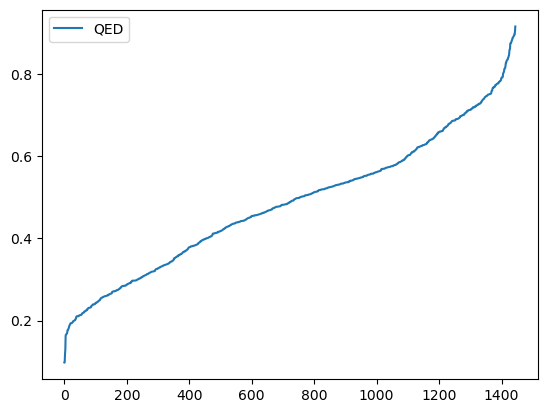

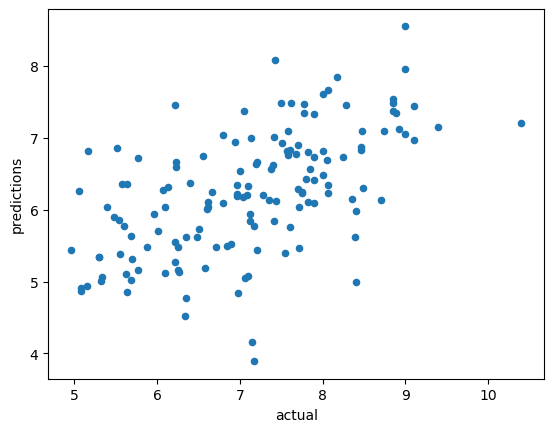

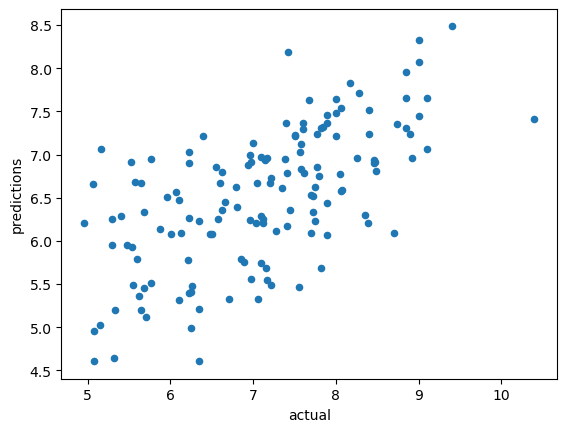

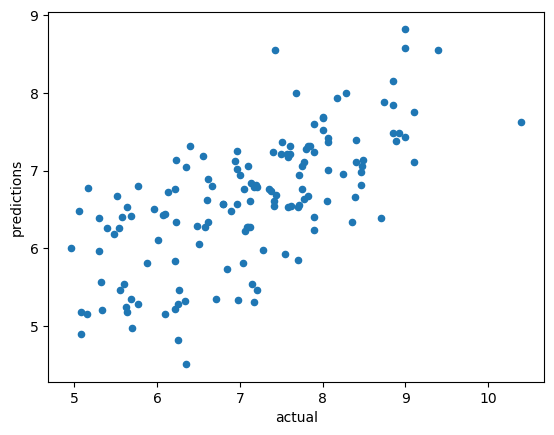

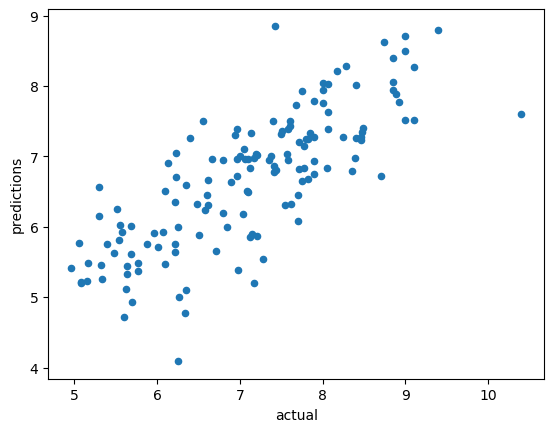

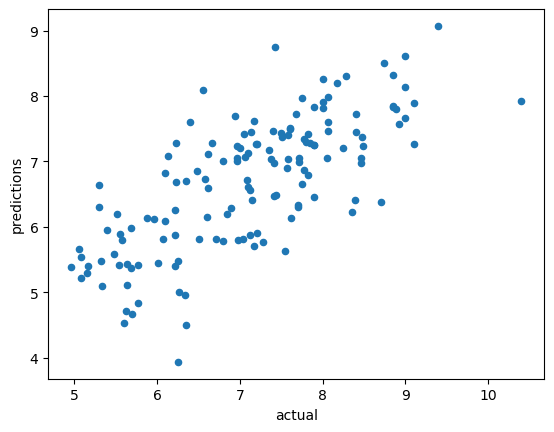

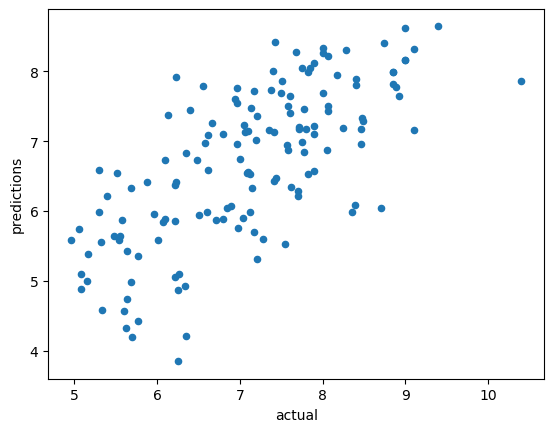

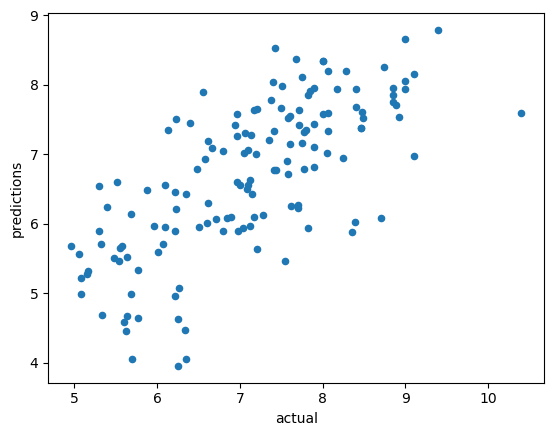

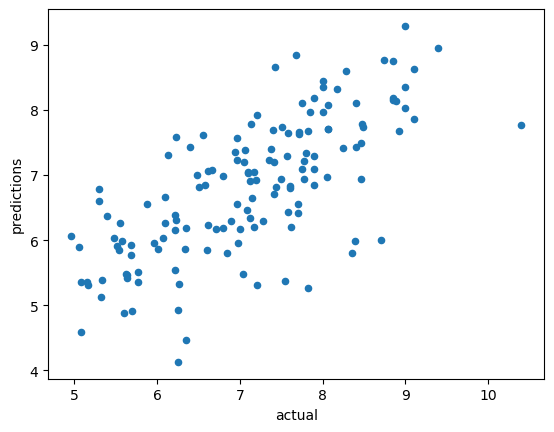

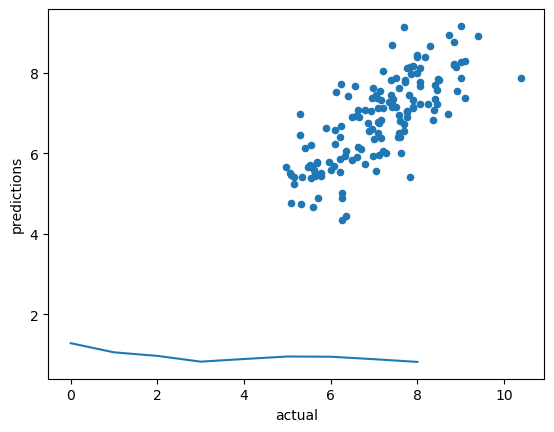

[1.2801377690043194, 1.0522642403319455, 0.9640593161784098, 0.8207178532777039, 0.8867921047459881, 0.9487724448645637, 0.9433450711718553, 0.88198839599431, 0.8141677581676215]


In [24]:
plt.plot(rmse)
plt.show()
print(rmse)